# Neural coding

## References:

### Convolutional Neural Networks (CNN)
Convolutional Neural Networks (CNNs) are a class of deep neural networks primarily used for tasks involving structured data, such as image and audio processing, where spatial or temporal hierarchies exist in the data. CNNs are particularly effective because they use convolutional layers that apply filters to input data to automatically detect and learn relevant patterns (e.g., edges in images, spectral features in audio) without requiring extensive preprocessing.

### Convolutional autoencoder
A neural network with unsupervised training, which means that we don't need to supply a target function. There is only a training set, which is also the target set. A convolutional autoencoder uses convolutional neural networks. An autoencoder maps the input signal to a lower dimensional representation using its encoder part. In this way it is similar for instance to an audio encoder, which compresses an audio signal into a representation with fewer bits than the original audio signal. The decoder part of an autoencoder maps the lower dimensional representation back into the higher dimensional representation. This is similar to an audio decoder, which decodes the compressed version back to an audio signal. The reconstruction after the decoder part should be as close as possible to the original. Hence the original (the training set) is also the target.

### Tensor
A tensor is a mathematical object that generalizes scalars, vectors, and matrices to higher dimensions. In deep learning and machine learning, a tensor is a data structure that is used to store multi-dimensional data, and it's the basic building block for computations in frameworks like PyTorch.

### Batch
A batch is a subset of the dataset that is processed in a single forward and backward pass through the network. Instead of using the entire dataset at once (which would be computationally demanding), training is often done in mini-batches. This approach allows for faster and more efficient training. The batch size is the number of samples (data points) in each batch.

### Epoch
An epoch is a complete pass through the entire training dataset. During each epoch, every sample in the dataset is used once to update the model's weights through the forward and backward propagation processes. Training a model often requires multiple epochs.

### Convolutional layer
A convolutional layer is a core building block in Convolutional Neural Networks (CNNs) and is primarily used to extract features from input data. Unlike fully connected layers, which connect each neuron to every input, convolutional layers use a smaller, localized region of the input to capture spatial or temporal hierarchies in data, making them efficient and highly effective for tasks involving structured data.

### Activation function
An activation function is a mathematical function applied to the output of a neural network layer, introducing non-linearity into the model. This non-linearity is essential for the network to learn complex patterns and relationships in the data, enabling it to solve more complex problems than simple linear functions. A common activation function the the ReLU (Rectified Linear Unit) which outputs the input directly if it's positive; otherwise, it outputs zero.

### Bias
In a neural network layer, bias is a learnable parameter added to the output of the convolution. It allows the model to shift the activation function output by some constant amount, helping the model fit the data better.

### Kernel
In a Convolutional Neural Network (CNN), a kernel (also known as a filter) is a small matrix of learnable weights used to detect specific features in the input data. The kernel slides (or convolves) over the input data, performing element-wise multiplication between its weights and the input data it covers, then sums these values to produce a single output value in a process known as convolution.

### Stride
In the context of Convolutional Neural Networks (CNNs), stride refers to the number of steps the kernel (or filter) moves each time it slides over the input data during the convolution operation. Stride controls how much the kernel shifts in each direction (horizontally and/or vertically in images, or along the temporal axis in audio processing).

### Padding
In Convolutional Neural Networks (CNNs), padding is a technique used to control the dimensions of the output feature map by adding extra "border" values around the input data. Padding is typically used to ensure that the size of the output is maintained or to control how much the feature map size is reduced after each convolutional layer.

### Loss function
A loss function is a mathematical function that measures the difference between the predicted output of a machine learning model and the actual target values (ground truth). It quantifies how "wrong" the model's predictions are, guiding the optimization process to adjust the model's parameters to minimize the error. Mean Squared Error (MSE) is a common loss function.

### Gradient descent
Gradient descent is an optimization algorithm used in machine learning and deep learning to minimize the loss function and improve model accuracy. The basic idea behind gradient descent is to iteratively adjust the model's parameters (weights and biases) in the direction that reduces the loss function, helping the model better fit the training data.

### Model weights
The parameters within a neural network that the model learns during training. These weights are the values that the model adjusts to better predict the target output from the input data. In deep learning, weights are crucial because they define the strength of connections between neurons in different layers of the network.

### Model predictions
Model predictions are the outputs generated by a trained machine learning model when given new input data. These predictions represent the model's "best guess" based on patterns it learned from training data.

### Optimizer
Algorithm used to adjust the parameters (such as weights) of a model in order to minimize the loss function during training. The optimizer updates the model parameters based on the gradients computed through backpropagation, with the goal of finding the optimal set of parameters that minimize the error between predicted and actual values. The Adam optimizer (short for Adaptive Moment Estimation) combines the best aspects of two other popular optimizers—AdaGrad and RMSprop—to provide a method that adjusts the learning rate for each parameter individually. This adaptability makes Adam particularly effective for large-scale and complex problems.

### Learning rate 
The learning rate is a crucial hyperparameter in machine learning, particularly in training neural networks. It controls the size of the steps that the optimization algorithm (usually gradient descent or a variant) takes when adjusting the model's weights to minimize the loss function.

### Pytorch
PyTorch is an open-source machine learning framework that provides a flexible and efficient platform for building and training deep learning models. It has become one of the most popular deep learning frameworks due to its flexibility, Pythonic interface, and extensive support for GPUs (Graphics Processing Units), which are crucial for accelerating deep learning computations.



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

In [7]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def signal2pytorch(x):
    # Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    return torch.from_numpy(x).reshape(1,1,-1)

## Part 1 - Convolution autoencoder

In [8]:
# Define the model architecture
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        
        # Analysis filter bank (encoder):
        # - Convolutional layer with a kernel size of 2048 and a stride of 1024, providing downsampling by 1024.
        # - Input has 1 channel (e.g., single audio channel) and output has 64 channels.
        # - Padding of 1023 ensures 'same' output size with respect to stride, so the output maintains useful spatial information.
        # - This layer learns 64 filters to extract features from the input signal.
        #self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2048, stride=1024, padding=1023, bias=True)

        self.encoder = nn.Sequential(
            # First convolutional layer: downsampling by a factor of 512
            nn.Conv1d(in_channels=1, out_channels=1024, kernel_size=2048, stride=512, padding=1023, bias=True),
            nn.ReLU(),  # Activation function
            
            # Second convolutional layer: reduces dimensionality to 256 channels
            nn.Conv1d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding=0, bias=True),
            nn.ReLU(),  # Activation function
            
            # Third convolutional layer: further reduces dimensionality to 64 channels
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=1, stride=1, padding=0, bias=True),
            nn.ReLU()  # Activation function
        )
        
        # Synthesis filter bank (decoder):
        # - Transposed convolutional layer with kernel size 2048 and stride 1024, acting as the "inverse" of the encoder.
        # - Input has 64 channels (from the encoder) and output has 1 channel, reconstructing the signal back to its original channel dimension.
        # - Padding of 1023 aligns the output size to match the input shape, ensuring symmetry in the encoder-decoder structure.
        #self.t_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

        self.decoder = nn.Sequential(
            # First transposed convolutional layer: expands dimensionality to 256 channels
            nn.ConvTranspose1d(in_channels=64, out_channels=256, kernel_size=1, stride=1, padding=0, bias=True),
            nn.ReLU(),  # Activation function
            
            # Second transposed convolutional layer: expands dimensionality to 1024 channels
            nn.ConvTranspose1d(in_channels=256, out_channels=1024, kernel_size=1, stride=1, padding=0, bias=True),
            nn.ReLU(),  # Activation function
            
            # Third transposed convolutional layer: upsampling to the original size with stride 512
            nn.ConvTranspose1d(in_channels=1024, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)
        )
        

    #def encoder(self, x):
        # Encoder pass (analysis step):
        # - Applies the convolutional layer defined in __init__ (self.conv1) on input x.
        # - Uses ReLU activation to introduce non-linearity, allowing the model to learn complex patterns.
     #   z = F.relu(self.conv1(x))
     #   return z  # Encoded features (latent representation)

   # def decoder(self, z):
        # Decoder pass (synthesis step):
        # - Applies the transposed convolutional layer (self.t_conv1) on the encoded features z.
        # - This step reconstructs the original input from its compressed latent representation.
    #    x = self.t_conv1(z)
    #    return x  # Reconstructed signal

    def forward(self, x):
        # Complete forward pass of the autoencoder:
        # - First encodes the input to obtain latent representation z.
        z = self.encoder(x)
        # - Then decodes z to reconstruct the output y.
        y = self.decoder(z)
        return y  # Final output, reconstructed signal


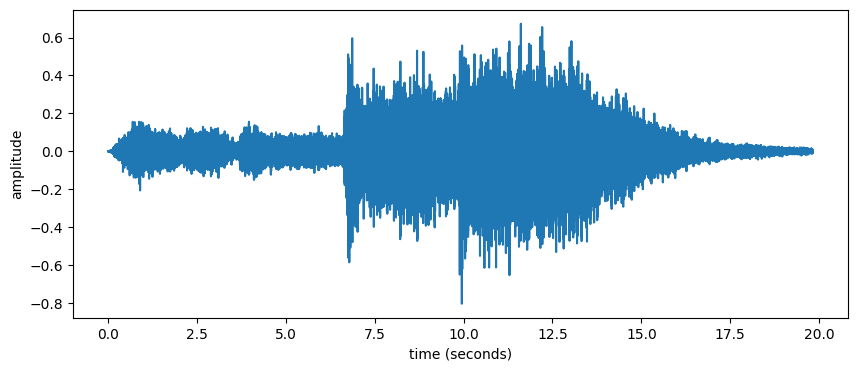

In [9]:
# Read training data

# set the batch size for training
batch=1

# load the audio file
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")

# convert the audio signal to PyTorch format
X_train = signal2pytorch(audio1).to(device)

# display training sound
display_sound(audio1, samplerate)

In [19]:
# Train model 

# create instance of model

model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()
# generate initial predictions for the training data
Ypred = model(X_train)
#length of the signal at the output of the network
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)
#the target signal with same length as model output
Y=X_train[:,:,:outputlen]

# define the size of each update step and initialize the optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model over a number of epochs
nepochs = 300
for epoch in range(nepochs):
  # generates predictions for the current epoch
  Ypred = model(X_train)
  # computes the error between the predicted output and the target output
  loss = loss_fn(Ypred, Y)
  # prints the loss every 50 epochs
  if epoch%50==0:
    print(f"Epoch [{epoch}/{nepochs}], Loss: {loss.item():.4f}")
  # Resets the gradients of all model parameters to zero before backpropagation
  optimizer.zero_grad()
  # Computes gradients of the loss with respect to model parameters via backpropagation
  loss.backward()
  # Updates model parameters based on gradients calculated
  optimizer.step()

Total number of parameters: 4753985
outputlen= 873986
Epoch [0/300], Loss: 0.0101
Epoch [50/300], Loss: 0.0030
Epoch [100/300], Loss: 0.0014
Epoch [150/300], Loss: 0.0007
Epoch [200/300], Loss: 0.0004
Epoch [250/300], Loss: 0.0003


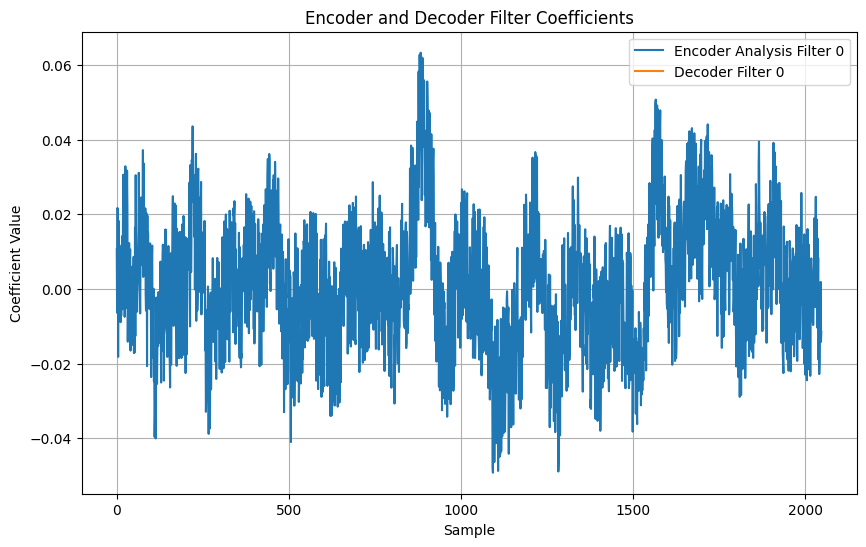

Number of input signal values: 874006
Number of elements in encoded signal: 109312


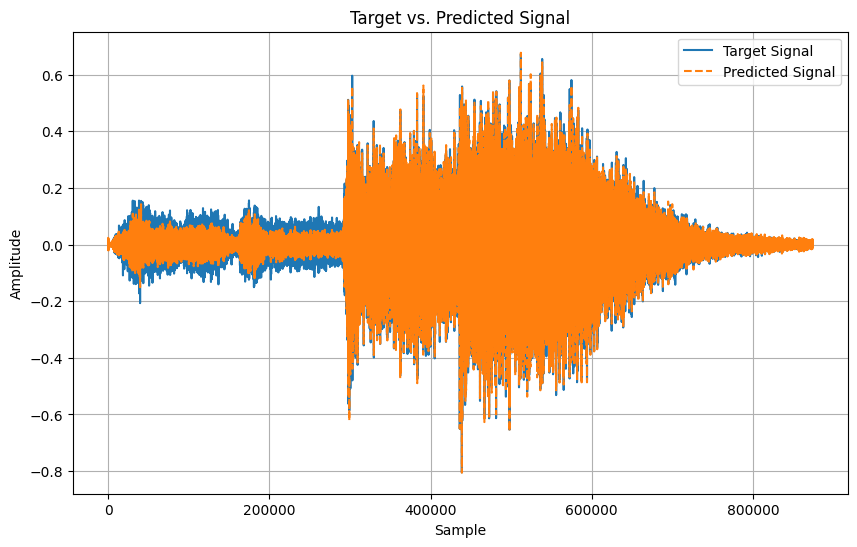

In [20]:
# Make model predictions using the training data

# Read and extract model weights
weights = model.state_dict()

# Convert the weights directly to NumPy arrays and transpose for plotting
#encoder_weights = weights['conv1.weight'][0, 0, :].numpy().T
#decoder_weights = weights['t_conv1.weight'][0, 0, :].numpy().T

# Access weights of specific layers within the encoder and decoder
encoder_weights = weights['encoder.0.weight'][0, 0, :].numpy().T  
decoder_weights = weights['decoder.2.weight'][0, 0, :].numpy().T  


# Plot obtained weights for encoder and decoder
plt.figure(figsize=(10, 6))
plt.plot(encoder_weights, label='Encoder Analysis Filter 0')
plt.plot(decoder_weights, label='Decoder Filter 0')
plt.xlabel('Sample')
plt.ylabel('Coefficient Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.legend()
plt.grid()
plt.show()

# Encode and decode to get predictions
encoded_signal = model.encoder(X_train)
print(f"Number of input signal values: {X_train.numel()}")
print(f"Number of elements in encoded signal: {encoded_signal.numel()}")

predictions = model.decoder(encoded_signal).detach().cpu().numpy()  # Convert to NumPy after detaching
target = Y.cpu().numpy()  # Convert target to NumPy for plotting

# Plot target signal and model predictions for comparison
plt.figure(figsize=(10, 6))
plt.plot(target[0, 0, :], label='Target Signal')
plt.plot(predictions[0, 0, :], label='Predicted Signal', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Target vs. Predicted Signal')
plt.legend()
plt.grid()
plt.show()

# Prepare reconstructed signal for playback (remove unnecessary dimensions)
reconstructed_signal = predictions[0, 0, :]

In [13]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(reconstructed_signal, rate=samplerate))

**Questions:**

1. Explore the impact of kernel_size and stride parameters. Change the size of these parameters and explain its effect in the quality of the reconstruction and the size of the encoded signal.

In a Convolutional Neural Network (CNN), a kernel is a small matrix of learnable weights used to detect specific features in the input data. The kernel slides over the input data, performing element-wise multiplication between its weights and the input data it covers, then sums these values to produce a single output value in a process known as convolution.
Increasing the kernel size makes the convolutional layers capture more of the signal's context at each step, which improve reconstruction quality but leads to a more "smoothed" effect as more input samples are aggregated.

In the Convolutional Neural Networks, stride refers to the number of steps the kernel moves each time it slides over the input data during the convolution operation. Stride controls how much the kernel shifts in each direction.
Increasing the stride will compress more the signal, resulting in a smaller representation. This can reduce the size of the encoded signal but may decrease reconstruction accuracy.

2. Increase the compression rate by introducing more convolutional layers in both encoder and decoder (check convolutional_autoencoder_complex.ipynb example). What is the tradeoff of doing this? Document your observations.

I modified the initial autoencoder by adding more convolutional layers in both the encoder and decoder. These additional layers allow the model to increase the compression rate by progressively downsampling the input signal. This leads to a more compact representation in the encoded space.
We can see that more layers allow the model to capture more complex patterns and produce more accurate reconstructions. Also with deeper layers we can see more efficient representation of data, leading to better compression. But more layers require more processing time, slowing down training. Also adding layers can increase the size of the signal, reducing efficiency.

3. Get a better reconstruction quality by modifying the number of epochs and / or learning rate. What are the optimal numbers? How does the number of epochs and learning rate affect the model's performance? What is the impact of training for too few or too many epochs?

The optimal number of epochs and learning rate is 300 and 1e-3 respectivly. 

The number of epochs determines how many times the model will see the entire dataset during training. If we have few epochs, the model may not have enough time to learn the underlying patterns and that leads to a poor reconstruction. And if we have too many epochs for example 1000, the performance on training data improves but generalization to new data worsens. Also is very slow.

The learning rate controls how much the model's weights are adjusted with each update. For a high learning rate the model converge too quickly, possibly and we have poor reconstruction. For a low learning can lead to better results if given enough time, but it takes a lot of time.
____

## Part 2 - Generalization of model

Explore the generalization quality of the model trained on a single sound.

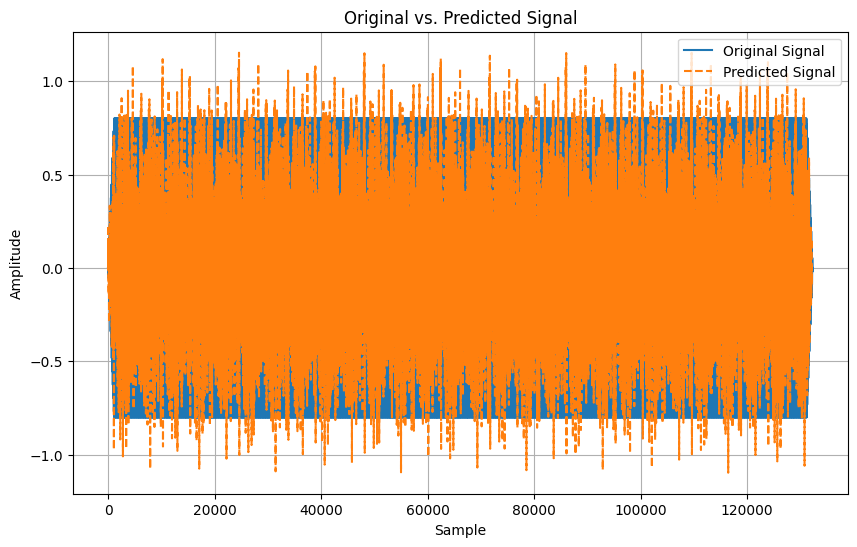

In [ ]:
# Encode/decode on signal different from the one used for training

# audio2, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("../sounds/sinewave.wav")
#Convert to pytorch format, batch is first dimension
X_test = signal2pytorch(audio2).to(device) 

# Make Predictions based on the obtained weights
predictions = model(X_test).detach().cpu().numpy()  # Ensure predictions are detached and on CPU

# Plot the original test signal and the model's predicted reconstruction
plt.figure(figsize=(10, 6))
plt.plot(X_test[0, 0, :].detach().cpu().numpy(), label='Original Signal')  # Original test signal, detached
plt.plot(predictions[0, 0, :], label='Predicted Signal', linestyle='--')  # Model prediction
plt.legend()
plt.title('Original vs. Predicted Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Prepare reconstructed signal for playback (remove unnecessary dimensions)
reconstructed_signal = predictions[0, 0, :]

In [ ]:
# play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(reconstructed_signal, rate=samplerate))

**Questions:**

1. Evaluate generality of trained model by using other sounds. Try on the other channel of Chinese orchestra sound (162095-chinese-orchestra-channel-2.wav). How does it perform in comparison with the sound used for training? Explain your observations?
2. Evaluate on a very different sound. Which are the ones for which the model performs poorly? Explain.
3. What could be done to improve the model generalization? (answer theoretically)
_______

## Part 3 - ENCODEC
Experiment with the Encodec neural codec.

In [ ]:
from IPython.display import Audio
from transformers import AutoProcessor, EncodecModel
import torch
import torchaudio

# Load the pretrained processor and model
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")
encodec = EncodecModel.from_pretrained("facebook/encodec_24khz")

In [ ]:
# load audio to encode
audio_path = "../sounds/721313-hangpan.wav"
# audio_path = '../sounds/synthetic.wav'
# audio_path = '../sounds/718782-sword-shing.wav'
# audio_path = '../sounds/632748-pavilion.wav'
# audio_path = '../sounds/263506-hallway.wav'

sample_rate = 24000

waveform, orig_sample_rate = torchaudio.load(audio_path)
waveform = waveform[:1] # Load first channel of the audio
waveform = torchaudio.functional.resample(waveform, orig_freq=orig_sample_rate, new_freq=sample_rate).squeeze(0) # Resample the audio

# Preprocess the audio
inputs = processor(raw_audio=waveform, sampling_rate=sample_rate, return_tensors="pt")
bandwidths = encodec.config.target_bandwidths
print(f"Available bandwidths: {bandwidths} kbps")

# Encode the audio
target_bandwidth = bandwidths[-1] # highest bandwidth
# target_bandwidth = bandwidths[0] # lowest bandwidth
encoder_outputs = encodec.encode(**inputs, bandwidth=target_bandwidth)

codes = encoder_outputs.audio_codes
scales = encoder_outputs.audio_scales

# compute bandwith
import math

print(f"Target bandwidth: {target_bandwidth:.2f} kbps")
duration = waveform.shape[-1] / sample_rate
# latent codes per second
cps = codes.shape[-2] * codes.shape[-1] / duration
# bits per codebook
bpc = math.log2(encodec.config.codebook_size)
calculated_bandwidth = cps * bpc / 1000
print(f"Calculated bandwidth: {calculated_bandwidth:.2f} kbps")

# Decode the audio
with torch.no_grad():
  decoder_outputs = encodec.decode(audio_codes=codes, audio_scales=scales)

audio = decoder_outputs.audio_values

print("Original")
display(Audio(waveform, rate=sample_rate))

print("Reconstructed")
display(Audio(audio.numpy().squeeze(), rate=sample_rate))

RuntimeError: Couldn't find appropriate backend to handle uri ../sounds/721313-hangpan.wav and format None.

In [ ]:
# Choose a bandwidth
target_bandwidth = bandwidths[-1]
print(f"Compression bandwidth: {target_bandwidth} kbps")

# Encode the audio
encoder_outputs = encodec.encode(**inputs, bandwidth=target_bandwidth)
codes = encoder_outputs.audio_codes
scales = encoder_outputs.audio_scales

# Save to .ecdc file
torch.save({"codes": codes, "scales": scales}, "compressed_audio.ecdc")

# Calculate compression rate
import os
original_size = os.path.getsize(audio_path)
compressed_size = os.path.getsize("compressed_audio.ecdc")
compression_rate = (1 - (compressed_size / original_size)) * 100
print(f"Compression rate: {compression_rate:.2f}%")

# Load back from .ecdc file
loaded_data = torch.load("compressed_audio.ecdc")
codes = loaded_data["codes"]
scales = loaded_data["scales"]

# Decode the audio
with torch.no_grad():
  decoder_outputs = encodec.decode(audio_codes=codes, audio_scales=scales)

audio = decoder_outputs.audio_values

# Display the audio
Audio(audio.numpy().squeeze(), rate=sample_rate)

Compression bandwidth: 24.0 kbps
Compression rate: 78.17%


/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_25099/3626542612.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load("compressed_audio.e

**Questions:**

1. Test different bandwidths of the encodec for the hangpan sound. What is the lowest bandwidth that still gives a good reconstruction? What is the compression rate you get for this bandwidth?
2. Encode 3 distinct sounds. Does the codec works equally well for all of them? What is the bandwidth threshold after which the quality degradation becomes noticable for all the respective sounds? Where does the difference come from? Support your explanations with necessary plots.
___